In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import randn, randint

In [12]:
# Run simulation once
def simulate_one_run(snr_db, max_errors, experiment_func):
    n_errors = 0.0
    n_experiments = 0.0
    while n_errors < max_errors:
        n_errors += experiment_func(snr_db)
        n_experiments += 1
    return n_errors / n_experiments

In [13]:
# Generate complex-valued noise
def gen_noise(N, snr_db):
    # Here we assume that signal has power 1
    sigma = np.sqrt(1 / (2 * 10 ** (snr_db / 10)))
    z_re = np.random.normal(0, 1, size=(N,))
    z_im = np.random.normal(0, 1, size=(N,))
    
    return (z_re + 1j * z_im) * sigma

In [14]:
# Generate codebook with R=1/2 for provided k
def generate_codebook(k):
    # Codebook is matrix 2^k x 2k
    # Elements are drawn from CN(0,1)
    codebook = randn(2 ** k, 2 * k) + 1j * randn(2 ** k, 2 * k)
    # Compute length of each codeword (row)
    lens = np.sqrt(np.sum(abs(codebook) ** 2, axis=1))
    assert(codebook.shape[0] == 2 ** k)
    # Normalize each codeword power to n^2, where n=2k (for R=1/2) - code space dimension
    # After this normalization each sample in each vector has average power 1
    for i in range(codebook.shape[0]):
        codebook[i] = codebook[i] / lens[i] * np.sqrt(2 * k)
    
    return codebook

In [15]:
# Experiment function for random coding
def random_coding(snr_db, k):
    # Generate codebook
    codebook = generate_codebook(k)

    # Generate bits
    bits = randint(0, 2 ** k)
    # Choose codeword from the codebook
    x = codebook[bits]
    assert(x.shape[0] == 2 * k)

    # Generate noise with corresponding snr in dB
    z = gen_noise(2 * k, snr_db)
    assert(z.shape[0] == 2 * k)

    # Model AWGN channel
    y = x + z
    
    # Decode according to maximum likelihood principle
    decoded_bits = np.argmin(np.sqrt(np.sum(abs(codebook - y) ** 2, axis=1)))
    assert(np.sqrt(np.sum(abs(codebook - y) ** 2, axis=1)).shape[0] == 2 ** k)
    
    # Return block error rate for this single experiment (0 or 1)
    return float(decoded_bits != bits)

In [16]:
# Plot results for different k from "data" dictionary
def plot_results(data):
    markers = {2:"v", 4:"o", 8:"d", 16:"x"}
    legend = []

    for k in list(data.keys()):
        lists = sorted(data[k].items())
        x, y = zip(*lists)

        plt.plot(x, y, marker=markers[k])
        legend.append(('Random coding, k=%d' % k))

        
    plt.yscale('log')
    plt.xlabel('Signal-to-noise ratio [dB]')
    plt.ylabel('Block Error Rate')
    plt.grid()
    plt.yticks([1,1e-1,1e-2])
    plt.ylim([1e-2,1])
    plt.legend(legend)
    plt.show()

In [8]:
# Set k range and SNR range to be used in simulation
k_vs_snr_db_range = {2: np.arange(-8, 5.5, 0.5), 4: np.arange(-8, 2.5, 0.5), \
            8: np.arange(-8, 1.5, 0.5), 16: np.arange(-8, 0, 0.5)}

data = dict()
# Run simulation for different k
for k in list(k_vs_snr_db_range.keys()):
    data[k] = dict()
    for snr_db in k_vs_snr_db_range[k]:
        data[k][snr_db] = simulate_one_run(
            snr_db, # SNR value
            10, # Maximum error count
            lambda x: random_coding(x, k) # Experiment function
        )

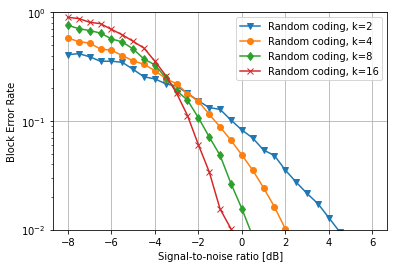

In [17]:
plot_results(data)